In [ ]:
pip install pyngrok

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score ,recall_score, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from flask import Flask, request, jsonify, render_template
from pyngrok import ngrok

In [ ]:
# Function to read CSV with multiple encoding attempts
def read_csv_with_multiple_encodings(file_path):
 encodings = ['utf-8', 'latin1', 'ISO-8859-1']
 for encoding in encodings:
  try:
    return pd.read_csv(file_path, encoding=encoding,low_memory=False)
  except UnicodeDecodeError:
    continue
 raise ValueError(f"Cannot decode file {file_path} with available encodings")

# File path for the Wednesday dataset
file_path = '/content/Wednesday-workingHours.pcap_ISCX.csv'

# Load the data
df = read_csv_with_multiple_encodings(file_path)

# Strip leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Print the column names to identify the target column
print("Column names:", df.columns)

# Replace infinite values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove columns with more than 50% missing values
df = df.loc[:, df.isnull().mean() < 0.5]

# Impute missing values with the mean for numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

# Separate numeric and non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
df_numeric = df.drop(columns=non_numeric_columns)

# Scale the numerical columns
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
df_scaled = scaler.fit_transform(df_numeric)

Column names: Index(['Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Le

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df is your dataframe and it contains the column 'Label'
# Ensure your dataframe 'df' is properly loaded here
# df = pd.read_csv('your_dataset.csv')

# Target column
target_column = 'Label'

# Check if the target column exists
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset. Please check the column names.")

# Encode categorical columns
label_encoders = {}
for column in df.select_dtypes(include=[object]).columns:
    label_encoders[column] = LabelEncoder().fit(df[column])
    df[column] = label_encoders[column].transform(df[column])

# Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['anomaly'] = iso_forest.fit_predict(df)

# Split data into features and target
X = df.drop(columns=[target_column, 'anomaly'])
y = df[target_column]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test_scaled = scaler.transform(X_test)        # Only transform on test data

# Intrusion Detection using Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)  # Fit on scaled training data

# Check for overlap
train_ids = set(X_train.index)
test_ids = set(X_test.index)
overlap = train_ids.intersection(test_ids)
print(f"Overlap between training and test sets: {overlap}")

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_scaled)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf, labels=rf_classifier.classes_)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('Random Forest Confusion Matrix')

# Save the confusion matrix plot
plt.savefig('/content/sample_data/confusion_matrix.png')
plt.close()

# Print the confusion matrix to the console
print("Confusion Matrix:")
print(cm)

# Optional: Evaluate model accuracy
from sklearn.metrics import accuracy_score
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")


Overlap between training and test sets: set()
Confusion Matrix:
[[5360    0    0]
 [   1   23    0]
 [   0    0    0]]
Accuracy: 0.99981426448737


In [ ]:
# Save the model to a pickle file
with open('rf_model.pkl', 'wb') as file:
 pickle.dump(rf_classifier, file)

# Save the label encoders
with open('label_encoders.pkl', 'wb') as file:
 pickle.dump(label_encoders, file)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
 pickle.dump(scaler, file)


In [ ]:
# Predict and evaluate Random Forest
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest Classifier - Accuracy: {accuracy_rf}")
print(f"Random Forest Classifier - Precision: {precision_rf}")
print(f"Random Forest Classifier - Recall: {recall_rf}")
print(f"Random Forest Classifier - F1 Score: {f1_rf}")

from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(rf_classifier, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Classifier - Accuracy: 0.9955423476968797
Random Forest Classifier - Precision: 0.9911045660578148
Random Forest Classifier - Recall: 0.9955423476968797
Random Forest Classifier - F1 Score: 0.9933185003081302
Cross-validation scores: [0.99976782 0.99930346 1.         0.99953553 1.        ]
Mean cross-validation score: 0.9997213622257635


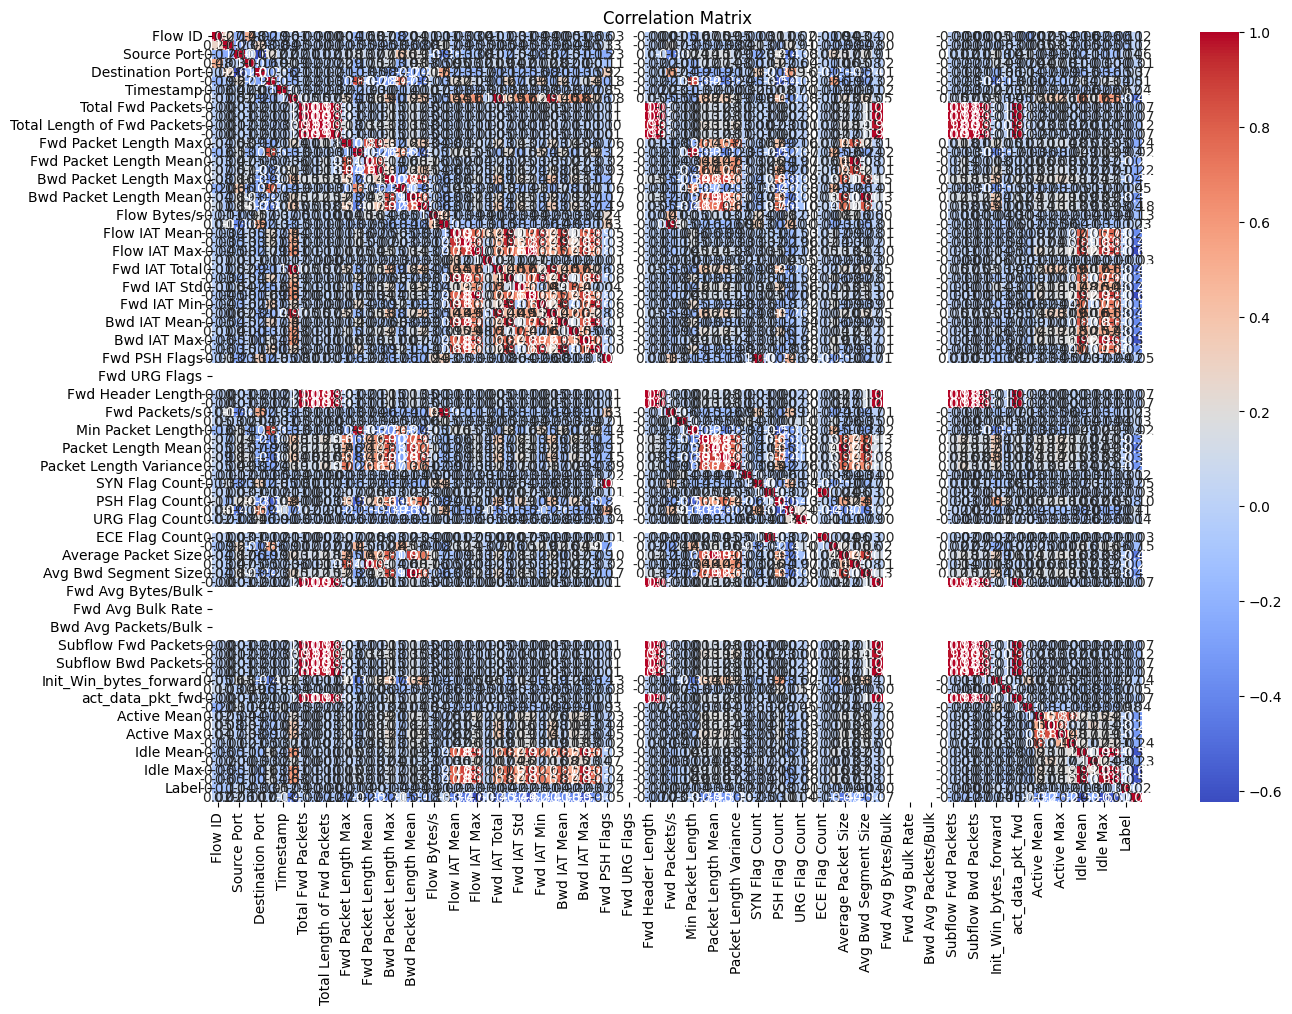

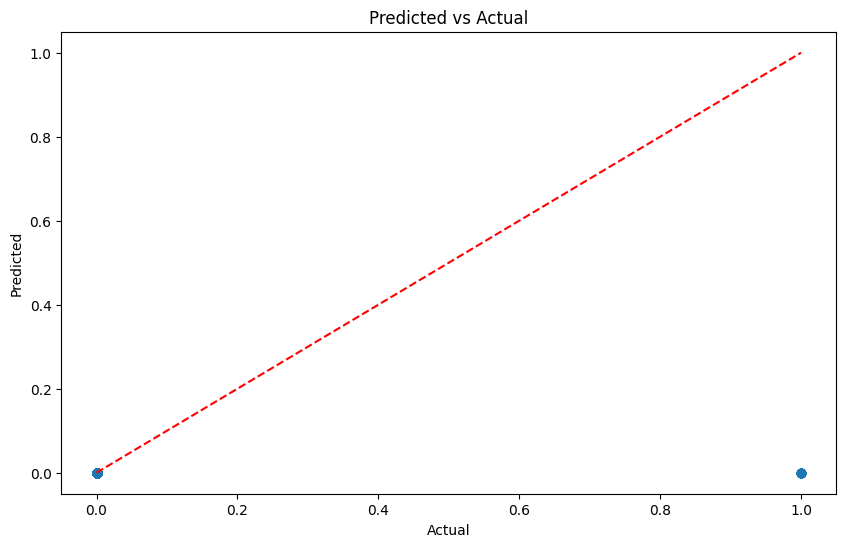

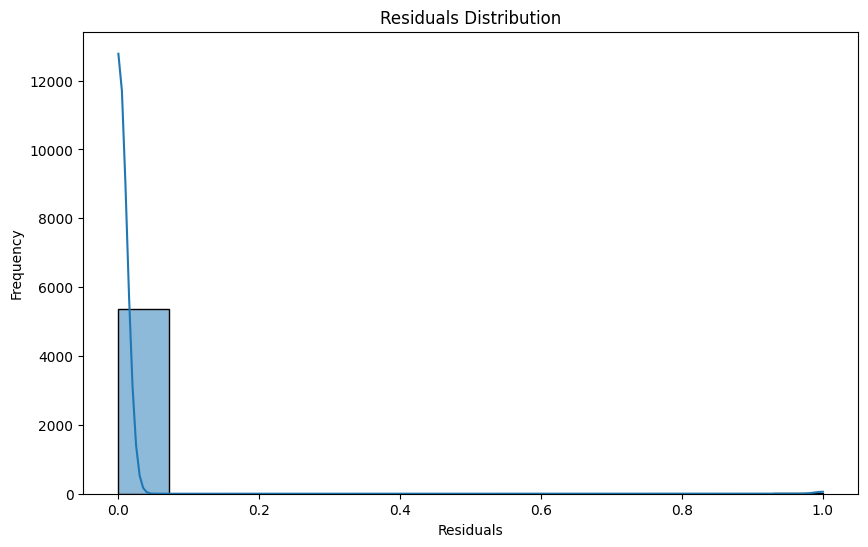

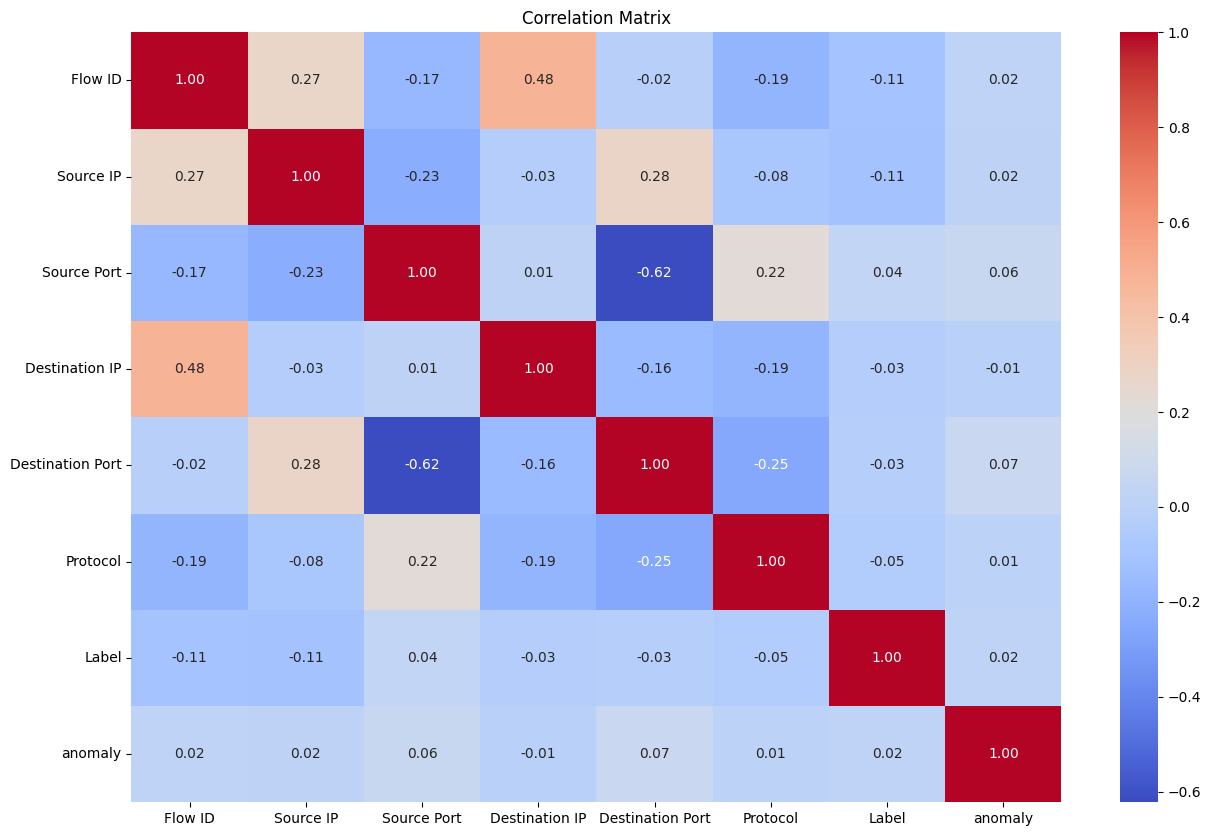

In [ ]:
def plot_predicted_vs_actual(y, y_pred_rf):
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred_rf, alpha=0.5)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Predicted vs Actual')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.show()

def plot_residuals(y, y_pred_rf):
    residuals = y - y_pred_rf
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

def plot_correlation_matrix(data):
    plt.figure(figsize=(15, 10))
    sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(df)

# Create new DataFrame without certain columns
df_new = df.drop(columns=['Timestamp', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min',
    'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean',
    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
    'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min',
    'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
    'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
    'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Down/Up Ratio',
    'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1',
    'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
    'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', 'Subflow Fwd Bytes',
    'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
    'act_data_pkt_fwd', 'min_seg_size_forward', 'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'])

plot_predicted_vs_actual(y_test, y_pred_rf)
plot_residuals(y_test, y_pred_rf)
plot_correlation_matrix(df_new)


In [ ]:
import os

# Create templates directory
os.makedirs('/content/sample_data/templates', exist_ok=True)

# Define the content of index.html
index_html_content = """
<!DOCTYPE html>
<html>
<head>
 <title>Cybersecurity Trained Model - Predictive Analysis</title>
 <style>
 body {
 font-family: Arial, sans-serif;
 margin: 0;
 padding: 0;
 background-color: #f0f0f0;
 color: #333;
 }
 header {
 background-color: #4CAF50;
 color: white;
 padding: 20px;
 text-align: center;
 }
 h1 {
 font-size: 2.5em;
 margin: 0;
 }
 .container {
 width: 80%;
 margin: 0 auto;
 padding: 20px;
 }
 .form-container {
 background: #fff;
 padding: 30px;
 border-radius: 8px;
 box-shadow: 0 0 15px rgba(0, 0, 0, 0.2);
 }
 label {
 font-weight: bold;
 margin-top: 10px;
 display: block;
 }
 input[type="text"], input[type="number"] {
 width: calc(100% - 20px);
 padding: 10px;
 margin: 10px 0;
 border: 1px solid #ccc;
 border-radius: 4px;
 font-size: 1em;
 }
 input[type="submit"] {
 background-color: #4CAF50;
 color: white;
 padding: 15px 25px;
 border: none;
 border-radius: 5px;
 cursor: pointer;
 font-size: 1.1em;
 }
 input[type="submit"]:hover {
 background-color: #45a049;
 }
 footer {
 text-align: center;
 padding: 10px;
 background-color: #4CAF50;
 color: white;
 position: fixed;
 bottom: 0;
 width: 100%;
 }
 .company-logo {
 max-width: 150px;
 display: block;
 margin: 0 auto 20px;
 }
 .welcome-text {
 font-size: 1.2em;
 margin: 0 0 20px;
 }
 .background-image {
 width: 100%;
 height: auto;
 opacity: 0.1;
 position: absolute;
 top: 0;
 left: 0;
 z-index: -1;
 }
 </style>
</head>
<body>
 <header>
   <h1>Cybersecurity Trained Model</h1>
   <p class="welcome-text">Enhance your network security with our predictive analytics.</p>
 </header>
 <div class="container">
   <div class="form-container">
     <h2>Network Traffic Data Form</h2>
     <form action="/predict" method="post">
       <label for="flow_id">Flow ID:</label>
       <input type="text" id="flow_id" name="flow_id" required>
       <label for="source_ip">Source IP:</label>
       <input type="text" id="source_ip" name="source_ip" required>
       <label for="source_port">Source Port:</label>
       <input type="number" id="source_port" name="source_port" required>
       <label for="destination_ip">Destination IP:</label>
       <input type="text" id="destination_ip" name="destination_ip" required>
       <label for="destination_port">Destination Port:</label>
       <input type="number" id="destination_port" name="destination_port" required>
       <label for="protocol">Protocol:</label>
       <input type="text" id="protocol" name="protocol" required>
       <label for="active_mean">Active Mean:</label>
       <input type="number" id="active_mean" name="active_mean" required>
       <label for="active_std">Active Std:</label>
       <input type="number" id="active_std" name="active_std" required>
       <label for="active_max">Active Max:</label>
       <input type="number" id="active_max" name="active_max" required>
       <label for="active_min">Active Min:</label>
       <input type="number" id="active_min" name="active_min" required>
       <label for="idle_mean">Idle Mean:</label>
       <input type="number" id="idle_mean" name="idle_mean" required>
       <label for="idle_std">Idle Std:</label>
       <input type="number" id="idle_std" name="idle_std" required>
       <label for="idle_max">Idle Max:</label>
       <input type="number" id="idle_max" name="idle_max" required>
       <label for="idle_min">Idle Min:</label>
       <input type="number" id="idle_min" name="idle_min" required>
       <input type="submit" value="Predict">
     </form>
   </div>
 </div>
 <footer>
   <p>&copy; 2024 Cybersecurity Trained Model. All rights reserved.</p>
 </footer>
 <img src="https://www.example.com/background-image.jpg" alt="Background Image" class="background-image">
</body>
</html>
"""

# Write the content to index.html
with open('/content/sample_data/templates/index.html', 'w') as file:
    file.write(index_html_content)

print("Created index.html at /content/sample_data/templates/index.html")

Created index.html at /content/sample_data/templates/index.html


In [ ]:
import os

# Create templates directory
os.makedirs('/content/sample_data/templates', exist_ok=True)

# Define the content of result.html
result_html_content = """
<!DOCTYPE html>
<html>
<head>
    <title>Prediction Result - Cybersecurity Trained Model</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            background-color: #f0f0f0;
            color: #333;
        }
        header {
            background-color: #4CAF50;
            color: white;
            padding: 20px;
            text-align: center;
        }
        h1 {
            font-size: 2.5em;
            margin: 0;
        }
        .container {
            width: 80%;
            margin: 0 auto;
            padding: 20px;
        }
        .result-container {
            background: #fff;
            padding: 30px;
            border-radius: 8px;
            box-shadow: 0 0 15px rgba(0, 0, 0, 0.2);
            text-align: center;
        }
        .result-container h2 {
            font-size: 2em;
            margin-bottom: 20px;
        }
        .result-container p {
            font-size: 1.5em;
            margin-bottom: 20px;
        }
        .result-container .prediction {
            font-size: 2em;
            font-weight: bold;
            color: #4CAF50;
        }
        .back-button {
            background-color: #4CAF50;
            color: white;
            padding: 15px 25px;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 1.1em;
            text-decoration: none;
        }
        .back-button:hover {
            background-color: #45a049;
        }
        footer {
            text-align: center;
            padding: 10px;
            background-color: #4CAF50;
            color: white;
            position: fixed;
            bottom: 0;
            width: 100%;
        }
        .background-image {
            width: 100%;
            height: auto;
            opacity: 0.1;
            position: absolute;
            top: 0;
            left: 0;
            z-index: -1;
        }
    </style>
</head>
<body>
    <header>
        <h1>Prediction Result</h1>
    </header>
    <div class="container">
        <div class="result-container">
            <h2>Analysis Result:</h2>
            <p>Your network traffic data has been analyzed. The prediction is:</p>
            <p class="prediction">{{ prediction }}</p>
            <a href="/" class="back-button">Go Back to Home</a>
        </div>
    </div>
    <footer>
        <p>&copy; 2024 Cybersecurity Trained Model. All rights reserved.</p>
    </footer>
</body>
</html>
"""

# Write the content to result.html
with open('/content/sample_data/templates/result.html', 'w') as file:
    file.write(result_html_content)

print("Created index.html at /content/sample_data/templates/result.html")

Created index.html at /content/sample_data/templates/result.html


In [ ]:
!pip install pyngrok
!pip install flask


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from flask import Flask, request, jsonify, render_template
from pyngrok import ngrok
import joblib

# Create Flask app
app = Flask(__name__, template_folder='/content/sample_data/templates')

# Load the trained RandomForest model
with open('rf_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the scaler
scaler = joblib.load('scaler.pkl')

# Load the label encoders
with open('label_encoders.pkl', 'rb') as file:
    label_encoders = pickle.load(file)

# Flask routes
@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get data from form
        data = request.form.to_dict()
        df = pd.DataFrame([data])

        # Ensure all required columns are present
        required_features = X.columns  # X is the features DataFrame from your training phase
        for feature in required_features:
            if feature not in df.columns:
                df[feature] = 0  # Handle missing features

        # Ensure the correct order of features
        df = df[required_features]

        # Encode categorical columns
        for column, encoder in label_encoders.items():
            if column in df.columns:
                df[column] = encoder.transform(df[column])
            else:
                df[column] = 0  # Handle missing categorical columns if any

        # Scale the features using the pre-fitted scaler
        scaled_features = scaler.transform(df)

        # Make predictions
        predictions = loaded_model.predict(scaled_features)

        # Render result.html with the prediction result
        return render_template('result.html', prediction=predictions[0])
    except Exception as e:
        return f"An error occurred: {e}", 500


# Set the authtoken for ngrok
ngrok.set_auth_token("2jR0DOkK7EnMmJanSKnosSLGMcc_318wFkEEEhZnXcFsWvcoM")

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print(f" * ngrok tunnel \"{public_url}\" ->\"http://127.0.0.1:8000\"")

# Run Flask app
if __name__ == '__main__':
    app.run(port=8000)


 * ngrok tunnel "NgrokTunnel: "https://bada-35-199-184-241.ngrok-free.app" -> "http://localhost:8000"" ->"http://127.0.0.1:8000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:8000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [11/Aug/2024 15:40:10] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Aug/2024 15:40:11] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [11/Aug/2024 15:42:01] "POST /predict HTTP/1.1" 500 -
